In [1]:
import yfinance as yf
import pandas as pd

btc = yf.download("BTC-USD", start="2025-05-06", end="2025-08-06", interval="1h")
eth = yf.download("ETH-USD", start="2025-05-06", end="2025-08-06", interval="1h")
btc = btc.reset_index()
btc['Datetime'] = pd.to_datetime(btc['Datetime'])

eth = eth.reset_index()
eth['Datetime'] = pd.to_datetime(eth['Datetime'])

btc.to_csv("BTC_1m_hourly.csv", index=False)
eth.to_csv("ETH_1m_hourly.csv", index=False)


print("OK:", btc.shape, eth.shape)

/var/folders/tx/w6h_l95x6612vyhm8b7dd5tm0000gn/T/ipykernel_9764/3483798610.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  btc = yf.download("BTC-USD", start="2025-05-06", end="2025-08-06", interval="1h")
[*********************100%***********************]  1 of 1 completed
/var/folders/tx/w6h_l95x6612vyhm8b7dd5tm0000gn/T/ipykernel_9764/3483798610.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  eth = yf.download("ETH-USD", start="2025-05-06", end="2025-08-06", interval="1h")
[*********************100%***********************]  1 of 1 completed

OK: (2208, 6) (2208, 6)


In [2]:
import pandas as pd
import numpy as np


# 假设 eth 是 Series（价格列）
# 转成一维 numpy 数组

eth_nonlag = eth[2:]     # t
eth_lag1   = eth[1:-1]   # t-1
eth_lag2   = eth[0:-2]  # t-2

btc_nolag = btc[2:]
btc_lag1   = btc[1:-1]
btc_lag2   = btc[0:-2]


# eth loc close price
Eth_y_t = eth_nonlag['Close'].values
Eth_y_t_1 = eth_lag1['Close'].values
Eth_y_t_2 = eth_lag2['Close'].values

# btc loc close price
Btc_y_t = btc_nolag['Close'].values
Btc_y_t_1 = btc_lag1['Close'].values
Btc_y_t_2 = btc_lag2['Close'].values

# matrix A
A = np.hstack([Eth_y_t_1/1000, Eth_y_t_2/1000, Btc_y_t_1/100000, Btc_y_t_2/100000]).astype(float)
y = Eth_y_t.astype(float) / 1000

print("A shape:", A.shape, " y shape:", y.shape)


A shape: (2206, 4)  y shape: (2206, 1)


In [3]:

# WEIGHT RLS


def weighted_rls_step(theta, P, row, y_t, beta):
    """
    Weighted RLS 单步更新
    theta: 当前参数向量 (p, 1)
    P: 当前逆协方差矩阵 (p, p)
    row: 当前样本 (p, 1)
    y_t: 当前目标值 (float)
    beta: 遗忘因子
    """
    newsample = row @ row.T
    theta = theta + (P @ row) * (y_t - row.T @ theta) / (beta + row.T @ P @ row)
    P = 1/beta * (P - (P @ newsample @ P) / (beta + row.T @ P @ row))
    return theta, P


In [4]:
def nlms_step(theta, row, y_t, eta=0.1):
    """
    NLMS 单步更新
    theta: 当前参数向量 (p, 1)
    row: 当前样本 (p, 1)
    y_t: 当前目标值 (float)
    eta: 学习率
    """
    theta = theta + ((eta * row) * (y_t - row.T @ theta)) / (1 + eta * row.T @ row)
    return theta


⚠ Step 111: 条件数 5022.19 > 5000，重置 P
⚠ Step 211: 条件数 5013.62 > 5000，重置 P
⚠ Step 313: 条件数 5044.08 > 5000，重置 P
⚠ Step 412: 条件数 5025.76 > 5000，重置 P
⚠ Step 512: 条件数 5033.03 > 5000，重置 P
⚠ Step 611: 条件数 5045.79 > 5000，重置 P
⚠ Step 711: 条件数 5104.38 > 5000，重置 P
⚠ Step 813: 条件数 5091.05 > 5000，重置 P
⚠ Step 908: 条件数 5030.10 > 5000，重置 P
⚠ Step 1008: 条件数 5060.84 > 5000，重置 P
⚠ Step 1110: 条件数 5004.05 > 5000，重置 P
⚠ Step 1216: 条件数 5076.37 > 5000，重置 P
⚠ Step 1320: 条件数 5108.67 > 5000，重置 P
⚠ Step 1421: 条件数 5090.98 > 5000，重置 P
⚠ Step 1522: 条件数 5109.52 > 5000，重置 P
⚠ Step 1613: 条件数 5052.95 > 5000，重置 P
⚠ Step 1701: 条件数 5119.78 > 5000，重置 P
RMSE: 0.0231
R²   : 0.9617


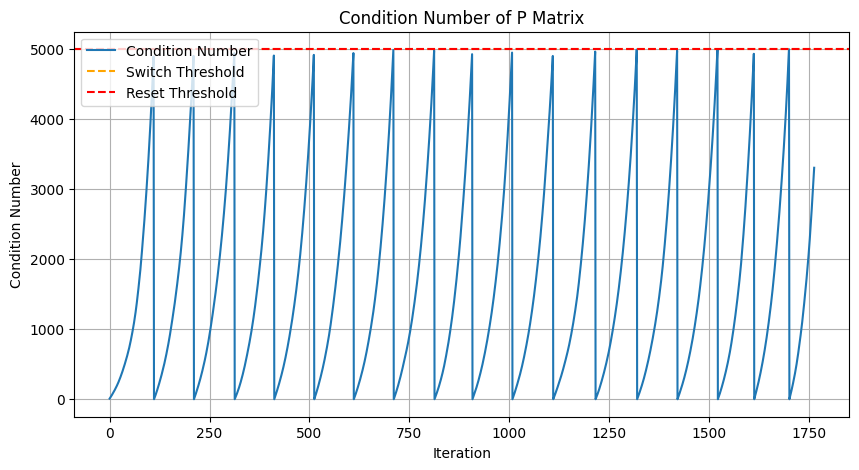

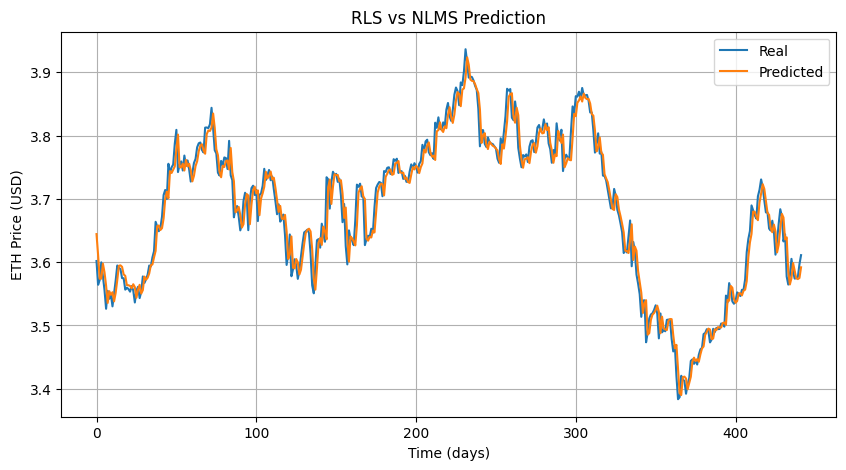

In [5]:
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt


n = A.shape[0]
split_idx = int(n * 0.8)
A_train, A_test = A[:split_idx], A[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# ==== 初始化 ====
beta = 0.98
eta = 0.1
cond_thresh_switch = 5000     # 切换到 NLMS
cond_thresh_reset = 5000   # P 重置条件

use_nlms = False
cond_list = []
mode_list = []

P = np.identity(A_train.shape[1])
theta_rls = np.zeros((A_train.shape[1], 1))   # RLS 参数
theta_nlms = np.zeros((A_train.shape[1], 1))  # NLMS 参数
theta = theta_rls.copy()  # 当前主预测器参数

# ==== 循环 ====
for i, (row, y_t) in enumerate(zip(A_train, y_train.flatten())):
    row = row.reshape(-1, 1)

    # ---- RLS 后台持续更新 ----
    theta_rls, P = weighted_rls_step(theta_rls, P, row, y_t, beta)
    cond_num = np.linalg.cond(P)

    # ---- 检查 P 是否需要重置 ----
    if cond_num > cond_thresh_reset:
        print(f"⚠ Step {i}: 条件数 {cond_num:.2f} > {cond_thresh_reset}，重置 P")
        P = np.identity(P.shape[0])
        cond_num = 1.0  # 重置后条件数

    # ---- 切换逻辑 ----
    if not use_nlms and cond_num > cond_thresh_switch:
        print(f"⚠ Step {i}: 条件数 {cond_num:.2f} > {cond_thresh_switch}，切到 NLMS")
        use_nlms = True

    elif use_nlms and cond_num < cond_thresh_switch:
        print(f"ℹ Step {i}: 条件数 {cond_num:.2f} < {cond_thresh_switch}，切回 RLS")
        use_nlms = False

    # ---- 主预测器更新 ----
    if use_nlms:
        theta_nlms = nlms_step(theta_nlms, row, y_t, eta)
        theta = theta_nlms
        mode_list.append("NLMS")
    else:
        theta = theta_rls
        mode_list.append("RLS")

    cond_list.append(cond_num)

# ==== 测试集预测 ====
y_pred_test = A_test @ theta

rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
r2 = r2_score(y_test, y_pred_test)
print(f"RMSE: {rmse:.4f}")
print(f"R²   : {r2:.4f}")

# ==== 条件数曲线 ====
plt.figure(figsize=(10, 5))
plt.plot(cond_list, label="Condition Number")
plt.axhline(cond_thresh_switch, color='orange', linestyle='--', label='Switch Threshold')
plt.axhline(cond_thresh_reset, color='red', linestyle='--', label='Reset Threshold')
plt.title("Condition Number of P Matrix")
plt.xlabel("Iteration")
plt.ylabel("Condition Number")
plt.legend()
plt.grid(True)
plt.show()

# ==== 预测对比图 ====
plt.figure(figsize=(10, 5))
plt.plot(y_test, label="Real")
plt.plot(y_pred_test, label="Predicted")
plt.title("RLS vs NLMS Prediction")
plt.xlabel("Time (days)")
plt.ylabel('ETH Price (USD)')
plt.legend()
plt.grid(True)
plt.show()